<a href="https://colab.research.google.com/github/Tony5t4rk/ML-2021-Spring/blob/main/Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Homework 2-1 Phoneme Classification**

作者: 刘阳

学习笔记：[機器學習2021 学习笔记-Deep Learning](https://www.wolai.com/tony5t4rk/fPrLCZXbVHWg5zxj5kDicY)

本HW01在[样例代码](https://colab.research.google.com/github/ga642381/ML2021-Spring/blob/main/HW02/HW02-1.ipynb#scrollTo=emUd7uS7crTz)的基础上进行修改。


# 挂载到Google Drive

In [86]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/Colab/ML 2021 Spring/HW02'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab/ML 2021 Spring/HW02


# 查看当前设备GPU

In [87]:
!nvidia-smi

Mon May  3 13:00:15 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    33W / 250W |    963MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# 从Google Drive下载数据

In [88]:
# !gdown --id '1HPkcmQmFGu-3OknddKIa5dNDsR05lIQR' --output data.zip
# !unzip data.zip
!apt-get -qq install -y tree
!tree -L 2

train_file = 'timit_11/train_11.npy'
train_label_file = 'timit_11/train_label_11.npy'
test_file = 'timit_11/test_11.npy'

.
├── data.zip
├── Learning curve of Deep Neural Network Model.svg
├── models
│   └── model.pth
├── timit_11
│   ├── test_11.npy
│   ├── train_11.npy
│   └── train_label_11.npy
└── timit.pred.csv

2 directories, 7 files


# 导入需要使用的模块

In [89]:
# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# sklearn
from sklearn.model_selection import train_test_split

# 数据处理
import numpy as np
import os
import gc

# 绘图
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
# 绘制矢量图片
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# 设置随机数种子（为了实验的可复现性）
my_seed = 42096
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(my_seed)
torch.manual_seed(my_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(my_seed)

# 定义画图工具函数

In [90]:
# 绘制深度神经网络学习曲线（训练和验证的Loss）
def plot_learning_curve(loss_record, title=''):
    total_steps = len(loss_record['train'])
    x_1 = range(total_steps)
    x_2 = x_1[::len(loss_record['train']) // len(loss_record['val'])]
    figure(figsize=(6, 4))
    plt.plot(x_1, loss_record['train'], c='tab:red', label='train')
    plt.plot(x_2, loss_record['val'], c='tab:cyan', label='val')
    plt.ylim(0.0, 5.)
    plt.xlabel('Training steps')
    plt.ylabel('Loss')
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.savefig('Learning curve of {}.svg'.format(title))
    plt.show()

# 预处理

## 读入数据、拆分训练集

In [91]:
def load_data(train_path, label_path, test_path, val_ratio):
    print('Loading Data...')

    train_x = np.load(train_path)
    train_y = np.load(label_path)
    test_x = np.load(test_path)

    train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=val_ratio, random_state=my_seed, stratify=train_y)

    print('Size of train set: ', train_x.shape)
    print('Size of val set: ', val_x.shape)
    print('Size of test data: ', test_x.shape)

    return train_x, val_x, train_y, val_y, test_x


## 数据集类

In [92]:
class TIMIT_Dataset(Dataset):
    def __init__(self, x, y=None):
        self.data = torch.from_numpy(x).float()
        if y is not None:
            y = y.astype(np.int)
            self.label = torch.LongTensor(y)
        else:
            self.label = None
        self.dim = self.data.shape[1]
    
    def __getitem__(self, index):
        if self.label is not None:
            return self.data[index], self.label[index]
        else:
            return self.data[index]

    def __len__(self):
        return len(self.data)

## 数据迭代器

In [93]:
def set_dataloader(train_path, label_path, test_path, val_ratio, batch_size):
    train_x, val_x, train_y, val_y, test_x = load_data(train_path, label_path, test_path, val_ratio)

    train_dataset = TIMIT_Dataset(train_x, train_y)
    val_dataset = TIMIT_Dataset(val_x, val_y)
    test_dataset = TIMIT_Dataset(test_x)
    
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    gc.collect()
    
    return train_dataloader, val_dataloader, test_dataloader

# 定义Model

In [94]:
class Classification(nn.Module):
    def __init__(self, input_dim):
        super(Classification, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.Sigmoid(),
            nn.Linear(1024, 512),
            nn.Sigmoid(),
            nn.Linear(512, 128),
            nn.Sigmoid(),
            nn.Linear(128, 39) 
        )

        self.criterion = nn.CrossEntropyLoss()
    
    def forward(self, x):
        return self.net(x)
    
    def calc_loss(self, pred, target):
        return self.criterion(pred, target)

# 训练 & 验证 & 测试

## 训练

In [95]:
def train(train_dataloader, val_dataloader, model, config, device):
    n_epochs = config['n_epochs']
    optimizer = getattr(torch.optim, config['optimizer'])(model.parameters(), **config['optim_hparams'])
    min_val_loss = float('inf')
    loss_record = {'train': [], 'val': []}
    early_stop_cnt = 0
    epoch = 0
    while epoch < n_epochs:
        model.train()
        for x, y in train_dataloader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            pred = model(x)
            loss = model.calc_loss(pred, y)
            loss.backward()
            optimizer.step()
            loss_record['train'].append(loss.detach().cpu().item())
        
        val_loss = val(val_dataloader, model, device)
        if val_loss < min_val_loss:
            min_val_loss = val_loss
            print('Saving model (epoch = {:4d}, loss = {:.4f})'.format(epoch + 1, min_val_loss))
            torch.save(model, config['model_path'])
            early_stop_cnt = 0
        else:
            early_stop_cnt += 1
        
        epoch += 1
        loss_record['val'].append(val_loss)
        if early_stop_cnt > config['early_stop']:
            break
    print('Finish train after {} epochs'.format(epoch))
    return min_val_loss, loss_record

## 验证

In [96]:
def val(val_dataloader, model, device):
    model.eval()
    total_loss = 0
    for x, y in val_dataloader:
        x, y = x.to(device), y.to(device)
        with torch.no_grad():
            pred = model(x)
            loss = model.calc_loss(pred, y)
        total_loss += loss.detach().cpu().item() * len(x)
    total_loss /= len(val_dataloader.dataset)
    return total_loss

## 测试

In [97]:
def test(test_dataloader, model, device):
    model.eval()
    preds = []
    for x in test_dataloader:
        x = x.to(device)
        with torch.no_grad():
            pred = model(x)
            _, pred = torch.max(pred, dim=1)
            preds.append(pred.detach().cpu())
    preds = torch.cat(preds, dim=0).numpy()
    return preds

# 配置Hyper-parameters

In [98]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'device: {device}')
os.makedirs('models', exist_ok=True)

config = {
    'n_epochs': 20,
    'batch_size': 64,
    'val_ratio': 0.2,
    'optimizer': 'Adam',
    'optim_hparams': {
        'lr': 0.0001
    },
    'early_stop': 200,
    'model_path': 'models/model.pth'
}

device: cuda


# 加载数据

In [99]:
train_dataloader, val_dataloader, test_dataloader = set_dataloader(train_file, train_label_file, test_file, config['val_ratio'], config['batch_size'])

Loading Data...
Size of train set:  (983945, 429)
Size of val set:  (245987, 429)
Size of test data:  (451552, 429)


# 加载Model

In [100]:
model = Classification(train_dataloader.dataset.dim).to(device)

# 开始训练

In [101]:
model_min_dev_loss, model_loss_record = train(train_dataloader, val_dataloader, model, config, device)

Saving model (epoch =    1, loss = 1.4647)
Saving model (epoch =    2, loss = 1.2409)
Saving model (epoch =    3, loss = 1.1177)
Saving model (epoch =    4, loss = 1.0437)
Saving model (epoch =    5, loss = 1.0028)
Saving model (epoch =    6, loss = 0.9633)
Saving model (epoch =    7, loss = 0.9428)
Saving model (epoch =    8, loss = 0.9176)
Saving model (epoch =    9, loss = 0.8985)
Saving model (epoch =   10, loss = 0.8841)
Saving model (epoch =   11, loss = 0.8709)
Saving model (epoch =   12, loss = 0.8676)
Saving model (epoch =   13, loss = 0.8552)
Saving model (epoch =   14, loss = 0.8498)
Saving model (epoch =   15, loss = 0.8414)
Saving model (epoch =   17, loss = 0.8317)
Saving model (epoch =   18, loss = 0.8243)
Finish train after 20 epochs


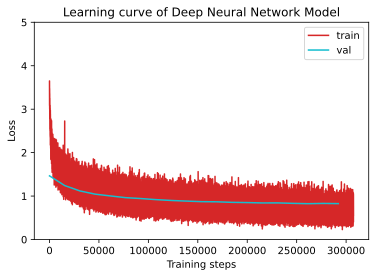

In [102]:
plot_learning_curve(model_loss_record, title='Deep Neural Network Model')

# 测试

In [103]:
def save_pred(preds, file):
    print('Saving result to {}'.format(file))
    with open(file, 'w') as fp:
        fp.write('Id,Class\n')
        for id, pred in enumerate(preds):
            fp.write('{},{}\n'.format(id, pred))

preds = test(test_dataloader, model, device)
save_pred(preds, 'timit.pred.csv')

Saving result to timit.pred.csv


# 结果

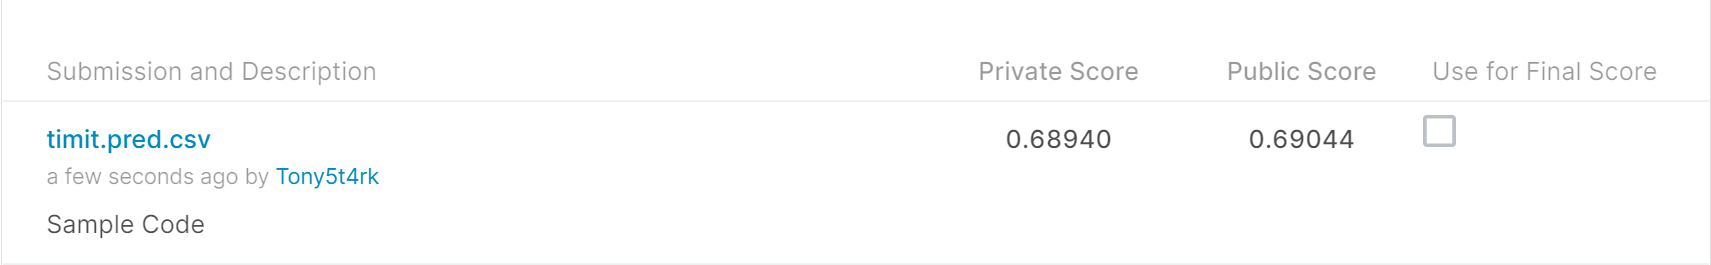